# Training and deploying our Keras CNN on SageMaker

Based on https://aws.amazon.com/blogs/machine-learning/train-and-deploy-keras-models-with-tensorflow-and-apache-mxnet-on-amazon-sagemaker/

We modified our Keras MNIST example from the previous exercise into the mnist-train-cnn.py script that you must upload into this Notebook's directory. It's the same code as the previous exercise, but with a little bit of extra stuff to allow hyperparameters to be passed in as arguments from SageMaker.

In [1]:
import sagemaker

sess = sagemaker.Session()
role = sagemaker.get_execution_role()

## Save the MNIST dataset to disk



In [2]:
import os
import keras
import numpy as np
from keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

os.makedirs("./data", exist_ok = True)

np.savez('./data/training', image=x_train, label=y_train)
np.savez('./data/validation', image=x_val, label=y_val)

Using TensorFlow backend.


## Upload MNIST data to S3

Note that sess.upload_data automatically creates an S3 bucket that meets the security criteria of starting with "sagemaker-".

In [3]:
prefix = 'keras-mnist'

training_input_path   = sess.upload_data('data/training.npz', key_prefix=prefix+'/training')
validation_input_path = sess.upload_data('data/validation.npz', key_prefix=prefix+'/validation')

print(training_input_path)
print(validation_input_path)

s3://sagemaker-us-east-1-159107795666/keras-mnist/training/training.npz
s3://sagemaker-us-east-1-159107795666/keras-mnist/validation/validation.npz


## Test out our CNN training script locally on the notebook instance

We'll test out running a single epoch, just to make sure the script works before we start spending money on P3 instances to train it further.

In [4]:
!pygmentize mnist-train-cnn.py

import argparse, os
import numpy as np

import tensorflow

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import multi_gpu_model

if __name__ == '__main__':

    parser = argparse.ArgumentParser()

    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--learning-rate', type=float, default=0.001)
    parser.add_argument('--batch-size', type=int, default=32)
    parser.add_argument('--gpu-count', type=int, default=os.environ['SM_NUM_GPUS'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--training', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    parser.add_argument('--validation', type=str, default=os.environ['SM_CHANNEL_VALIDATION'])

    args, _ = parser.parse_

In [5]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(entry_point='mnist-train-cnn.py', 
                          role=role,
                          instance_count=1, 
                          instance_type='local',
                          framework_version='1.12', 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={'epochs': 1}
                         )

In [6]:
tf_estimator.fit({'training': training_input_path, 'validation': validation_input_path})

Creating tmp0xjn47a9_algo-1-x79s2_1 ... 
Attaching to tmp0xjn47a9_algo-1-x79s2_12mdone
algo-1-x79s2_1  | 2019-09-25 19:57:50,758 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-x79s2_1  | 2019-09-25 19:57:50,764 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-x79s2_1  | 2019-09-25 19:57:51,406 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-x79s2_1  | 2019-09-25 19:57:51,424 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-x79s2_1  | 2019-09-25 19:57:51,438 sagemaker-containers INFO     Invoking user script
algo-1-x79s2_1  | 
algo-1-x79s2_1  | Training Env:
algo-1-x79s2_1  | 
algo-1-x79s2_1  | {
algo-1-x79s2_1  |     "additional_framework_parameters": {},
algo-1-x79s2_1  |     "channel_input_dirs": {
algo-1-x79s2_1  |         "training": "/opt/ml/input/data/training",
algo-1-x79s2_1  |         "validation": "/opt/ml/input/data/valida

algo-1-x79s2_1  | Train on 60000 samples, validate on 10000 samples
algo-1-x79s2_1  | Epoch 1/1
algo-1-x79s2_1  |  - 86s - loss: 0.2041 - acc: 0.9392 - val_loss: 0.0477 - val_acc: 0.9839
algo-1-x79s2_1  | Validation loss    : 0.047663420390663666
algo-1-x79s2_1  | Validation accuracy: 0.9839
algo-1-x79s2_1  | WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/simple_save.py:85: calling SavedModelBuilder.add_meta_graph_and_variables (from tensorflow.python.saved_model.builder_impl) with legacy_init_op is deprecated and will be removed in a future version.
algo-1-x79s2_1  | Instructions for updating:
algo-1-x79s2_1  | Pass your op to the equivalent parameter main_op instead.
algo-1-x79s2_1  | 2019-09-25 19:59:23,376 sagemaker-containers INFO     Reporting training SUCCESS
tmp0xjn47a9_algo-1-x79s2_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


## Train on a GPU instance with 10 epochs

Now that we're sure it works, we can start spending money on beefier servers to train our CNN over more epochs.

In [7]:
tf_estimator = TensorFlow(entry_point='mnist-train-cnn.py', 
                          role=role,
                          instance_count=1, 
                          instance_type='ml.p3.2xlarge',
                          framework_version='1.12', 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={
                              'epochs': 10,
                              'batch-size': 32,
                              'learning-rate': 0.001}
                         )

In [8]:
tf_estimator.fit({'training': training_input_path, 'validation': validation_input_path})

2019-09-25 20:00:54 Starting - Starting the training job........................
2019-09-25 20:04:34 Starting - Launching requested ML instances......
2019-09-25 20:05:37 Starting - Preparing the instances for training......
2019-09-25 20:06:38 Downloading - Downloading input data...
2019-09-25 20:07:26 Training - Training image download completed. Training in progress...2019-09-25 20:07:29,248 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-09-25 20:07:29,643 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training",
        "validation": "/opt/ml/input/data/validation"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch-size": 32,
        "learning-rate": 0.001,
        "mode

 - 7s - loss: 0.0486 - acc: 0.9856 - val_loss: 0.0258 - val_acc: 0.9915
Epoch 5/20
 - 7s - loss: 0.0404 - acc: 0.9877 - val_loss: 0.0244 - val_acc: 0.9934
Epoch 6/20
 - 7s - loss: 0.0352 - acc: 0.9891 - val_loss: 0.0360 - val_acc: 0.9910
Epoch 7/20
 - 7s - loss: 0.0317 - acc: 0.9899 - val_loss: 0.0293 - val_acc: 0.9923
Epoch 8/20
 - 7s - loss: 0.0290 - acc: 0.9908 - val_loss: 0.0276 - val_acc: 0.9928
Epoch 9/20
 - 7s - loss: 0.0247 - acc: 0.9922 - val_loss: 0.0316 - val_acc: 0.9911
Epoch 10/20
 - 7s - loss: 0.0237 - acc: 0.9924 - val_loss: 0.0319 - val_acc: 0.9925
Epoch 11/20
 - 7s - loss: 0.0225 - acc: 0.9926 - val_loss: 0.0313 - val_acc: 0.9921
Epoch 12/20
 - 7s - loss: 0.0175 - acc: 0.9943 - val_loss: 0.0349 - val_acc: 0.9928
Epoch 13/20
 - 7s - loss: 0.0187 - acc: 0.9940 - val_loss: 0.0353 - val_acc: 0.9924
Epoch 14/20
 - 7s - loss: 0.0182 - acc: 0.9944 - val_loss: 0.0322 - val_acc: 0.9924
Epoch 15/20
 - 7s - loss: 0.0171 - acc: 0.9947 - val_loss: 0.0290 - val_acc: 0.9928
Epoch 16/

## Deploy the model

To keep costs low, we'll deploy our model to a C5 instance to make inferences. You could also use GPU instances which would be faster, but at higher cost. Note we are also using an Elastic Inference accelerator here.

In [9]:
import time

tf_endpoint_name = 'keras-tf-mnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_predictor = tf_estimator.deploy(initial_instance_count=1,
                         instance_type='ml.c5.large',        
                         accelerator_type='ml.eia1.medium',  
                         endpoint_name=tf_endpoint_name)     

--------------------------------------------------------------------------------------------------!

## Make predictions with the deployed model

Predicted labels are: [0 6 0 4 1]


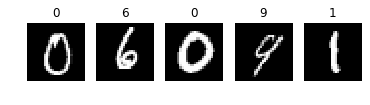

In [10]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(x_val.shape[0] - 1), num_samples)
images = x_val[indices]/255
labels = y_val[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
prediction = tf_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction)
predicted_label = prediction.argmax(axis=1)
print('Predicted labels are: {}'.format(predicted_label))

## Clean up the deployment endpoint

In [11]:
sess.delete_endpoint(endpoint_name=tf_endpoint_name)

## Find the best hyperparameters with Automatic Model Tuning

This is by far the most expensive part of this exercise; we're going to use a fair amount of time on P3 instances here. If you're worried about your AWS costs, skip the rest of this notebook and just shut down your SageMaker notebook instance now.

In [12]:
tf_estimator = TensorFlow(entry_point='mnist-train-cnn.py', 
                          role=role,
                          instance_count=1, 
                          instance_type='ml.p3.2xlarge',
                          framework_version='1.12', 
                          py_version='py3',
                          script_mode=True
                         )

In [13]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {
    'epochs':        IntegerParameter(5, 20),
    'learning-rate': ContinuousParameter(0.0001, 0.1, scaling_type='Logarithmic'), 
    'batch-size':    IntegerParameter(32, 1024),
}

objective_metric_name = 'val_acc'
objective_type = 'Maximize'
metric_definitions = [{'Name': 'val_acc', 'Regex': 'val_acc: ([0-9\\.]+)'}]

tuner = HyperparameterTuner(tf_estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=10,
                            max_parallel_jobs=2,
                            objective_type=objective_type)

In [14]:
tuner.fit({'training': training_input_path, 'validation': validation_input_path})

## Deploy the best model

In [15]:
import time

tf_endpoint_name = 'keras-tf-mnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_predictor = tuner.deploy(initial_instance_count=1,
                         instance_type='ml.c5.large',       
                         accelerator_type='ml.eia1.medium',
                         endpoint_name=tf_endpoint_name)

2019-09-25 20:47:35 Starting - Preparing the instances for training
2019-09-25 20:47:35 Downloading - Downloading input data
2019-09-25 20:47:35 Training - Training image download completed. Training in progress.
2019-09-25 20:47:35 Uploading - Uploading generated training model
2019-09-25 20:47:35 Completed - Training job completed2019-09-25 20:46:46,319 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-09-25 20:46:46,319 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value val_acc to Json.
Returning the value itself
2019-09-25 20:46:46,347 sagemaker_tensorflow_container.training INFO     Appending the training job name to model_dir: s3://sagemaker-us-east-1-159107795666/sagemaker-tensorflow-scriptmode-2019-09-25-20-22-24-343/model/sagemaker-tensorflow-190925-2022-009-7fd3495e/model
2019-09-25 20:46:47,037 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value val_ac

--------------------------------------------------------------------------------------!

## Predict again

Predicted labels are: [1 2 6 9 5]


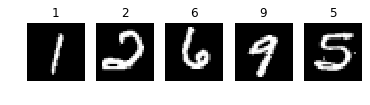

In [16]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(x_val.shape[0] - 1), num_samples)
images = x_val[indices]/255
labels = y_val[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
prediction = tf_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction)
predicted_label = prediction.argmax(axis=1)
print('Predicted labels are: {}'.format(predicted_label))

## Clean up

In [17]:
sess.delete_endpoint(endpoint_name=tf_endpoint_name)

## Remember to shut down your notebook instance too!